# Notes

All the logarithms used are base 2. <br>
Assumes 2 self-interested agents alternating turns. <br>
Baseline (1 for each agent) gets updated after each episode ends (see corpses). <br>
Rewards only possible at the end of each game. <br>
Uses same (numerical) encoder for both item context and proposal. Reference code uses 3 distinct ones. It also has max_utility = num_types instead of 10 for us.<br>
Check how message policy works again; paper seemed to imply that each output of the lstm is a letter. (we take the hidden output and make a probability over letters out of it).<br>

# Libraries

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# Network
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Optimizer
import torch.optim as optim

# cuda
use_cuda = 0

# Random seeds for testing
num_seed = 0
torch.manual_seed(num_seed)
if torch.cuda.is_available() and use_cuda:
    torch.cuda.manual_seed(num_seed)
np.random.seed(num_seed)

# Utility functions
from utility import truncated_poisson_sampling, create_item_pool, create_agent_utility, rewards_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [27]:
# Game setup
num_agents = 2         # Number of agents playing the game
num_types = 3          # Number of item types
max_item = 5           # Maximum number of each item in a pool
max_utility = 5       # Maximum utility value for agents

# Turn sampling
lam = 7                # Poisson parameter
max_N = 10             # Maximum number of turns
min_N = 4              # Minimum number of turns

# Linguistic channel
num_vocab = 10         # Symbol vocabulary size for linguistic channel
len_message = 6        # Linguistic message length

# Training
alpha = 0.001          # learning rate
N_ep = 100           # Number of episodes
num_games = 128        # Number of games per episode (batch size)

# Appendix
lambda1 = 0.05         # Entropy regularizer for pi_term
lambda2 = 0.0001        # Entropy regularizer for pi_utt
lambda3 = 0.005        # Entropy regularizer for pi_prop
smoothing_const = 0.7  # Smoothing constant for the exponential moving average baseline

# Miscellaneous
ep_time = int(max(1,N_ep/10))         # Print time every ep_time episodes
ep_record = int(max(1,N_ep/1000))        # Record training curve every ep_record episodes
save_plot = False

# Network

In [28]:
class combined_policy(nn.Module):
    def __init__(self, embedding_dim = 100, batch_size = 128, num_layers = 1, bias = True, batch_first = False, dropout = 0, bidirectional = False):
        super(combined_policy, self).__init__()
        # Save variables
        self.embedding_dim = embedding_dim # Hidden layer dimensions
        self.batch_size = batch_size       # Batch size (updated every forward pass)
        self.log_p = torch.zeros([batch_size,1], requires_grad=True)                     # Store policy log likelihood for REINFORCE
        if torch.cuda.is_available() and use_cuda:
            self.log_p = self.log_p.cuda()
        
        # Encoding -------------------------------------------------------------
        
        # Numerical encoder
        self.encoder1 = nn.Embedding(max_utility+1, embedding_dim)
        # Linguistic encoder
        self.encoder2 = nn.Embedding(num_vocab+1, embedding_dim)
        
        # Item context LSTM
        self.lstm1 = nn.LSTM(embedding_dim, embedding_dim, num_layers, bias, batch_first, dropout, bidirectional)
        # Linguistic LSTM
        self.lstm2 = nn.LSTM(embedding_dim, embedding_dim, num_layers, bias, batch_first, dropout, bidirectional)
        # Proposal LSTM
        self.lstm3 = nn.LSTM(embedding_dim, embedding_dim, num_layers, bias, batch_first, dropout, bidirectional)
        
        # Outputs of the 3 LSTMS get concatenated together
        
        # Feed-forward
        self.ff = nn.Linear(3*embedding_dim, embedding_dim)
        
        # Output of feed-forward is the input for the policy networks
        
        # Policy ---------------------------------------------------------------
        
        # Termination policy
        self.policy_term = nn.Linear(embedding_dim, 1)
        # Linguistic policy
        self.policy_ling = nn.LSTM(embedding_dim, embedding_dim, num_layers, bias, batch_first, dropout, bidirectional)
        self.ff_ling = nn.Linear(embedding_dim, num_vocab)
        # Proposal policies
        self.policy_prop = nn.ModuleList([nn.Linear(embedding_dim, max_item+1) for i in range(num_types)])
        
    def forward(self, x, test, batch_size=128):
        # Inputs --------------------------------------------------------------------
        # x = list of three elements consisting of:
        #   1. item context (longtensor of shape batch_size x (2*num_types))
        #   2. previous linguistic message (longtensor of shape batch_size x len_message)
        #   3. previous proposal (longtensor of shape batch_size x num_types)
        # test = whether training or testing (testing selects actions greedily)
        # batch_size = batch size
        # Outputs -------------------------------------------------------------------
        # term = binary variable where 1 indicates proposal accepted => game finished (longtensor of shape batch_size x 1)
        # message = crafted linguistic message (longtensor of shape batch_size x len_message)
        # prop = crafted proposal (longtensor of shape batch_size x num_types)
        # entropy_loss = Number containing the sum of policy entropies (should be total entropy by additivity)
        
        # Update batch_size variable (changes throughout training due to sieving (see survivors below))
        self.batch_size = batch_size
        
        # Extract inputs ------------------------------------------------------------
        
        # Item context
        x1 = x[0]
        # Previous linguistic message
        x2 = x[1]
        # Previous proposal
        x3 = x[2]  

        # Encoding ------------------------------------------------------------------

        # Initial embedding
        x1 = self.encoder1(x1).transpose(0,1)
        x2 = self.encoder2(x2).transpose(0,1)
        x3 = self.encoder1(x3).transpose(0,1) # Same encoder as item context
        
            
        # LSTM for item context
        h1 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial hidden
        c1 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial cell
        if torch.cuda.is_available() and use_cuda:
            h1 = h1.cuda()
            c1 = c1.cuda()

        for i in range(x1.size()[0]):
            _, (h1,c1) = self.lstm1(x1[i].view(1,self.batch_size,self.embedding_dim),(h1,c1))
        x1_encoded = h1
        
        # LSTM for linguistic
        h2 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial hidden
        c2 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial cell
        if torch.cuda.is_available() and use_cuda:
            h2 = h2.cuda()
            c2 = c2.cuda()

        for i in range(x2.size()[0]):
            _, (h2,c2) = self.lstm2(x2[i].view(1,self.batch_size,self.embedding_dim),(h2,c2))
        x2_encoded = h2
        
        # LSTM for proposal
        h3 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial hidden
        c3 = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial cell
        if torch.cuda.is_available() and use_cuda:
            h3 = h3.cuda()
            c3 = c3.cuda()

        for i in range(x3.size()[0]):
            _, (h3,c3) = self.lstm2(x3[i].view(1,self.batch_size,self.embedding_dim),(h3,c3))
        x3_encoded = h3

        # Concatenate side-by-side
        h = torch.cat([x1_encoded,x2_encoded,x3_encoded],2).view(self.batch_size,-1)

        # Feedforward
        h = self.ff(h)
        h = F.relu(h) # Hidden layer input for policy networks
        
        # Policy ------------------------------------------------------------------

        # Termination -----------------------------------------------
        p_term = F.sigmoid(self.policy_term(h)).float()

        # Entropy
        one_tensor = torch.ones(self.batch_size,1)
        if torch.cuda.is_available() and use_cuda:
            one_tensor = one_tensor.cuda()
        entropy_term = -(p_term * (p_term+1e-8).log()) - ((one_tensor-p_term) * (one_tensor-p_term+1e-8).log())
        
        if test:
            # Greedy
            term = torch.round(p_term).long()
        else:
            # Sample
            term = torch.bernoulli(p_term).long()
            
        # log p for REINFORCE
        log_p_term = torch.zeros(self.batch_size,1)
        if torch.cuda.is_available() and use_cuda:
            log_p_term = log_p_term.cuda()

        log_p_term = ((term.float() * p_term) + ((one_tensor-term.float()) * (one_tensor-p_term))+1e-8).log()

        # Linguistic construction ----------------------------------
        h_ling = h.clone().view(1,self.batch_size,self.embedding_dim) # Initial hidden state
        c_ling = torch.zeros(1,self.batch_size,self.embedding_dim) # Initial cell state
        letter = torch.zeros(self.batch_size,1).long() # Initial letter (dummy)
        entropy_letter = torch.zeros([self.batch_size,len_message])
        if torch.cuda.is_available() and use_cuda:
            c_ling = c_ling.cuda()
            letter = letter.cuda()
            entropy_letter = entropy_letter.cuda()
        
        # log p for REINFORCE 
        log_p_letter = torch.zeros([self.batch_size,1])
        if torch.cuda.is_available() and use_cuda:
            log_p_letter = log_p_letter.cuda()

        message = torch.zeros(self.batch_size,len_message) # Message
        if torch.cuda.is_available() and use_cuda:
            message = message.cuda()
        for i in range(len_message):
            embedded_letter = self.encoder2(letter)

            _, (h_ling,c_ling) = self.policy_ling(embedded_letter.view(1,self.batch_size,self.embedding_dim),(h_ling,c_ling))
            logit = self.ff_ling(h_ling.view(self.batch_size,self.embedding_dim))
            p_letter = F.softmax(logit,dim=1).float()

            entropy_letter[:,i] = -torch.sum(p_letter*(p_letter+1e-8).log(),1)

            if test:
                # Greedy
                letter = p_letter.argmax(dim=1).view(self.batch_size,1).long()
            else:
                # Sample
                letter = torch.multinomial(p_letter,1).long()
                
            # Gather the probabilities for the letters we've picked
            probs = torch.gather(p_letter, 1, letter)
            log_p_letter = log_p_letter + (probs+1e-8).log()
                
            message[:,i] = letter.squeeze()
            
        message = message.long()
        entropy_letter = torch.sum(entropy_letter,1,keepdim=True)     
   
        # Proposal ----------------------------------------------
        p_prop = []
        prop = []
        
        #prop = torch.zeros([self.batch_size,num_types]).long()
        entropy_prop_list = [0,0,0]
        
        # log p for REINFORCE 
        log_p_prop = torch.zeros([self.batch_size,1])
        if torch.cuda.is_available() and use_cuda:
            log_p_prop = log_p_prop.cuda()

        for i in range(num_types):
            p_prop.append(F.sigmoid(self.policy_prop[i](h)))
            
            entropy_prop_list[i] = -torch.sum(p_prop[i]*(p_prop[i]+1e-8).log(),1,keepdim=True)
            
            p_prop[i] = p_prop[i].view(self.batch_size,max_item+1)

            if test:
                # Greedy
                #prop[:,i] = p_prop[i].argmax(dim=1)
                prop.append(p_prop[i].argmax(dim=1))
            else:
                # Sample
                #prop[:,i] = torch.multinomial(p_prop,1)
                prop.append(torch.multinomial(p_prop,1))
                
            # Gather the probabilities for the letters we've picked
            probs = torch.gather(p_prop[i], 1, prop[i].view(self.batch_size,1))
            log_p_prop = log_p_prop + (probs+1e-8).log()
              
        prop = torch.stack(prop).transpose(0,1)
        entropy_prop = torch.sum(torch.cat(entropy_prop_list,1),1,keepdim=True)

        # Combine -----------------------------------------------------------------
        entropy_loss = -(lambda1*entropy_term + lambda3*entropy_prop + lambda2*entropy_letter)
        
        #print(entropy_loss.size())
        entropy_loss = entropy_loss.mean()
        #print(entropy_loss)
        self.log_p = self.log_p + log_p_term + log_p_letter + log_p_prop

        return (term,message,prop, entropy_loss)

# Network test

In [29]:
net = combined_policy()
if torch.cuda.is_available() and use_cuda:
    net = net.cuda()

# Dummy inputs
x = torch.randint(0,max_item,[128,6]).long()
y = torch.randint(0,num_vocab,[128,6]).long()
z = torch.randint(0,max_item,[128,3]).long()
if torch.cuda.is_available() and use_cuda:
    x = x.cuda()
    y = y.cuda()
    z = z.cuda()

blah = net([x,y,z],True)

# Initialize agents
Agents = []
for i in range(num_agents):
    Agents.append(combined_policy())
    if torch.cuda.is_available() and use_cuda:
        Agents[i] = Agents[i].cuda()

# Training

In [30]:
baselines = [0 for _ in range(num_agents)] # Baselines for reward calculation

# Initialize optimizers for learning
optimizers = []
for i in range(num_agents):
    optimizers.append(optim.Adam(Agents[i].parameters()))
    
# Recording train reward (see end of episode)
r_list = []
for i in range(num_agents):
    r_list.append([])

print('Start ----------------')
time_start = time.time()
time_p1 = time.time()
# Loop over episodes
for i_ep in range(N_ep):
    # Setting up games -----------------------------------------------------------------------
    
    # Game setup
    
    # Truncated Poisson sampling for number of turns in each game
    N = truncated_poisson_sampling(lam, min_N, max_N, num_games)
    
    # Item pools for each game
    pool = create_item_pool(num_types, max_item, num_games)
    
    # Item contexts for each game
    item_contexts = [] # Each agent has different utilities (but same pool)
    for i in range(num_agents):
        utility = create_agent_utility(num_types, max_utility, num_games)
        item_contexts.append(torch.cat([pool, utility],1))
        
    # For getting rid of finished games
    survivors = torch.ones(num_games).nonzero()               # Keeps track of ongoing games; everyone alive initially
    num_alive = len(survivors)                                # Actual batch size for each turn (initially num_games)
    
    # Initial inputs to the network
    prev_messages = torch.zeros(num_games, len_message).long() # Previous linguistic message for each game
    prev_proposals = torch.zeros(num_games, num_types).long()  # Previous proposal for each game

    # For keeping track of sum of all rewards in the episode (used to calculate mean)
    reward_sums = torch.zeros(2)
    
    # Initialize loss
    losses = []
    for j in range(num_agents):
        losses.append(torch.zeros([],requires_grad=True))
    
    # Initialize log_p for REINFORCE
    for j in range(num_agents):
        Agents[j].log_p = torch.zeros([num_alive,1], requires_grad = True)

    # cuda stuff
    if torch.cuda.is_available() and use_cuda:
        N = N.cuda()
        pool = pool.cuda()
        
        for j in range(num_agents):
            item_contexts[j] = item_contexts[j].cuda()
            Agents[j].log_p = Agents[j].log_p.cuda()
            losses[j] = losses[j].cuda()
        
        survivors = survivors.cuda()
        prev_messages = prev_messages.cuda()
        prev_proposals = prev_proposals.cuda()
        
        reward_sums = reward_sums.cuda()

    # Play the games -------------------------------------------------------------------------
    for i_turn in range(max_N): # Loop through maximum possible number of turns for all games
        
        reward_losses = []
        entropy_losses = []
        for j in range(num_agents):
            # Losses for each agent
            reward_losses.append(torch.zeros([],requires_grad=True))
            entropy_losses.append(torch.zeros([],requires_grad=True))
            
            if torch.cuda.is_available() and use_cuda:
                reward_losses[j] = reward_losses[j].cuda()
                entropy_losses[j] = entropy_losses[j].cuda()
                
        
        # Agent IDs
        id_1 = i_turn % 2    # Current player
        id_2 = int(not id_1) # Other player
        
        # Remove finished games (batch size decreases)
        N = N[survivors].view(num_alive, 1)
        pool = pool[survivors].view(num_alive, num_types)
        prev_messages = prev_messages[survivors].view(num_alive, len_message)
        prev_proposals = prev_proposals[survivors].view(num_alive, num_types)
        if torch.cuda.is_available() and use_cuda: # Necessary?
            N = N.cuda()
            pool = pool.cuda()
            prev_messages = prev_messages.cuda()
            prev_proposals = prev_proposals.cuda()
        for j in range(num_agents):
            item_contexts[j] = item_contexts[j][survivors].view(num_alive,num_types*2)
            Agents[j].log_p = Agents[j].log_p[survivors].view(num_alive,1)
            if torch.cuda.is_available() and use_cuda:
                item_contexts[j] = item_contexts[j].cuda() # Necessaire?
        
        # Agent currently playing
        Agent = Agents[id_1]             
        item_context = item_contexts[id_1]
        
        # Play the game -------------------------------------------------------------
        term, prev_messages, proposals, entropy_loss = Agent([item_context, prev_messages, prev_proposals], True, num_alive)
        entropy_losses[id_1] = entropy_loss
        
        # Compute reward loss (assumes 2 agents) ------------------------------------
        
        # Games terminated by the current agent (previous proposal accepted)
        finishers = term.squeeze().nonzero()          # squeeze is for getting rid of extra useless dimension that pops up for some reason
        num_finishers = len(finishers)

        # On the first turn there is no prev. proposal so terminating gives zero reward
        if num_finishers != 0 and i_turn != 0:
            pool_12 = pool[finishers].view(num_finishers,num_types)
            
            share_2 = prev_proposals[finishers].view(num_finishers,num_types) # Share of other (previous proposal) 
            share_1 = pool_12 - share_2 # Share of this agent (remainder)
            
            # Zero reward if proposal exceeds pool
            invalid_batches = torch.sum(share_2>pool_12,1)>0
            share_2[invalid_batches] = 0
            share_1[invalid_batches] = 0
            
            utility_1 = item_contexts[id_1][:,num_types:] # Recall that item context is a concatenation of pool and utility
            utility_1 = utility_1[finishers].view(num_finishers,num_types)
            utility_2 = item_contexts[id_2][:,num_types:]
            utility_2 = utility_2[finishers].view(num_finishers,num_types)

            log_p_1 = Agents[id_1].log_p[finishers].view(num_finishers,1)
            log_p_2 = Agents[id_2].log_p[finishers].view(num_finishers,1)

            # Calculate reward and reward losses
            r1, rl1 = rewards_func(share_1, utility_1, pool_12, log_p_1, baselines[id_1])
            r2, rl2 = rewards_func(share_2, utility_2, pool_12, log_p_2, baselines[id_2])
            
            # Add rewards and reward losses
            reward_losses[id_1] = rl1
            reward_losses[id_2] = rl2

            # Summing over all finished games
            reward_sums[id_1] = reward_sums[id_1] + r1.sum()
            reward_sums[id_2] = reward_sums[id_2] + r2.sum()
            
            # Accumulate reward loss
            losses[id_1] += rl1
            losses[id_2] += rl2
            
        # Accumulate entropy loss
        losses[id_1] = losses[id_1] + entropy_losses[id_1]
        losses[id_2] = losses[id_2] + entropy_losses[id_2]

        prev_proposals = proposals # Don't need previous proposals anymore so update it
        
        
        # Wrapping up the end of turn ------------------------------------------------
        # Remove finished games
        # In term and term_N, element = 1 means die
        term_N = (N <= (i_turn+1)).view(num_alive,1).long() # Last turn reached; i_turn + 1 since i_turn starts counting from 0
        # In survivors, element = 1 means live
        survivors = (term+term_N) == 0

        # Check if everyone's dead
        if survivors.sum() == 0: # If all games over, break episode
            break;
            
        # Reshape
        survivors = ((term+term_N) == 0).nonzero()[:,0].view(-1,1)
        num_alive = len(survivors) # Number of survivors
        
    # End of episode
    
    # Gradient descent
    for i in range(num_agents):
        # optimize
        optimizers[i].zero_grad()
        losses[i].backward()
        #print(losses[i])
        #print(Agents[i].ff_ling.weight.grad)
        optimizers[i].step()
    
    for j in range(num_agents):
        r_mean = reward_sums[j]/num_games # Overall episode batch-averaged reward
        
        # Update baseline with batch-averaged reward
        baselines[j] = smoothing_const * baselines[j] + (1-smoothing_const)*r_mean
        
        # Record batch-averaged reward
        if (i_ep % ep_record == 0):
            r_list[j].append(r_mean)

    # Record partial runtime
    if (i_ep % ep_time == 0) and (i_ep != 0):
        time_p2 = time.time()
        print('Runtime for episodes ' + str(i_ep-ep_time) + '-' + str(i_ep) + ': ' + str(time_p2 - time_p1) + 's')
        time_p1 = time_p2

print('End ------------------')
time_finish = time.time()
print('Total runtime: ' + str(time_finish-time_start) + 's')

# Save trained models

#for i in range(num_agents):
#    torch.save(Agents[0].state_dict(),'saved_model_agent_' + str(i) + '.pt')
    
# Template for loading

#Agents[0].load_state_dict(torch.load('saved_model.pt'))

Start ----------------
Runtime for episodes 0-10: 1.04689359664917s
Runtime for episodes 10-20: 0.9557099342346191s
Runtime for episodes 20-30: 1.5979328155517578s
Runtime for episodes 30-40: 0.7955899238586426s
Runtime for episodes 40-50: 0.8343038558959961s
Runtime for episodes 50-60: 1.1012766361236572s
Runtime for episodes 60-70: 0.729727029800415s
Runtime for episodes 70-80: 1.0104353427886963s
Runtime for episodes 80-90: 0.6696772575378418s
End ------------------
Total runtime: 9.335510730743408s


In [31]:
#Agents[0].ff.weight.grad

In [32]:
#list(Agents[1].parameters())

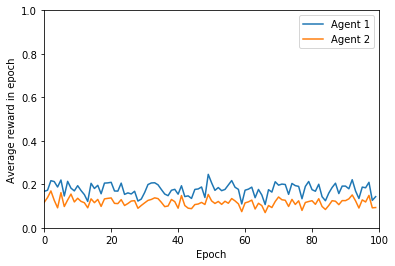

In [33]:
epoch_list = np.arange(len(r_list[0]))*ep_record
plt.plot(epoch_list,r_list[0], label='Agent 1')
plt.plot(epoch_list,r_list[1], label='Agent 2')
plt.ylabel('Average reward in epoch')
plt.xlabel('Epoch')
plt.xlim([0,ep_record*len(r_list[0])])
plt.ylim([0,1])
plt.legend()
if save_plot:
    plt.savefig('N_ep='+str(N_ep)+'_seed='+str(num_seed)+'_mean.png')
plt.show()

In [34]:
# Dummy inputs
x = torch.randint(0,max_item,[1,6]).long()
y = torch.randint(0,num_vocab,[1,6]).long()
z = torch.randint(0,max_item,[1,3]).long()
if torch.cuda.is_available() and use_cuda:
    x = x.cuda()
    y = y.cuda()
    z = z.cuda()